In [1]:
# A décommenter à la première exécution si jupyter se plaint de ne pas trouver oracledb
#!pip install --upgrade oracledb

In [2]:
# Compléter ici les imports dont vous avez besoin, ne pas modifier ceux déjà présents
import getpass
from os import getenv
import pandas as pd
import oracledb
import warnings
import matplotlib.pyplot as plt
import folium

In [3]:
sydney_coords = [-33.8688, 151.2093]

# Créer une carte centrée sur Sydney
sydney_map = folium.Map(location=sydney_coords, width=1200, height=250)

# Ajouter un marqueur pour Sydney
folium.Marker(location=sydney_coords, popup='Sydney').add_to(sydney_map)

# Afficher la carte
sydney_map

In [4]:
# Nécessaire pour éviter les problèmes de session
class Connexion(object):
    def __init__(self, login, password):
        self.conn = oracledb.connect(
            user=login,
            password=password,
            host="oracle.iut-orsay.fr",
            port=1521,
            sid="etudom",
        )
        self.conn.autocommit = False

    def __enter__(self):
        self.conn.autocommit = False
        return self.conn

    def __exit__(self, *args):
        self.conn.close()

In [5]:
# La fonction ci-dessous est à utiliser pour exécuter une requête et stocker les résultats dans un dataframe Pandas sans afficher d’alerte.
# Vous pouvez vous en inspirer pour créer vos propres fonctions.
def requete_vers_dataframe(connexion_data, requete, valeurs = None):
    with Connexion(login=connexion_data['login'], password=connexion_data['password']) as connexion:
        warnings.simplefilter(action='ignore', category=UserWarning)
        if valeurs is not None:
            df = pd.read_sql(requete, connexion, params=valeurs)
        else:
            df = pd.read_sql(requete, connexion)
        warnings.simplefilter("always") 
        return df

In [6]:
# Saisir ci-dessous l'édition des JO qui vous a été attribuée. Cela correspond au LibelleHote dans la table HOTE de la base de données
# Par exemple EDITION_JO = "2020 Summer Olympics"
EDITION_JO = "2000 Summer Olympics"
# Saisir ci-dessous le login court de la base utilisée pour votre carnet
SCHEMA = "KRICHA2"

# TABLEAU DE BORD DES JO

## Partie consultation des données

In [7]:
# On demande à l'utilisateur son login et mot de passe pour pouvoir accéder à la base de données
if getenv("DB_LOGIN") is None:
    login = input("Login : ")
else:
    login = getenv("DB_LOGIN")
if getenv("DB_PASS") is None:
    password = getpass.getpass("Mot de passe : ")
else:
    password = getenv("DB_PASS")
conn = {'login': login, 'password': password}

In [8]:
# On vérifie que l'utilisateur est bien connecté à la base de données, que le schéma est bon, et qu'on trouve la bonne édition des JO
data = requete_vers_dataframe(conn, f"SELECT * FROM {SCHEMA}.HOTE WHERE LibelleHote LIKE (:libelle)",{"libelle":EDITION_JO})
id_hote = int(data.IDHOTE.iloc[0])
print(f"Identifiant de l’hôte : {id_hote}")

Identifiant de l’hôte : 25


### Statistiques de base : participation

#### Nombre de nations participant à ces JO

In [9]:
# Calculer avec une requête et afficher le nombre de nations participant à cette édition
nationJO = requete_vers_dataframe(conn, f"""SELECT COUNT(DISTINCT NOC) AS "nbNationJO" FROM (
SELECT NOC FROM {SCHEMA}.EVENEMENT E
INNER JOIN {SCHEMA}.PARTICIPATION_INDIVIDUELLE PI ON PI.idEvent = E.idEvenement
WHERE IDHOTE = '{id_hote}'
UNION ALL
SELECT NOC FROM {SCHEMA}.EVENEMENT E
INNER JOIN {SCHEMA}.PARTICIPATION_EQUIPE PE ON PE.idEvenement = E.idEvenement
INNER JOIN {SCHEMA}.EQUIPE E ON E.idEquipe = PE.idEquipe
WHERE IDHOTE = '{id_hote}')""")

nationJO

,nbNationJO
0,200


#### Nombre d'athlètes participant à ces JO, répartition par genre et /ou par pays

In [10]:
# Calculer avec une requête et afficher le nombre d’athlètes participant et la répartition par genre et/ou par pays

athleteJO = requete_vers_dataframe(conn, f"""SELECT idAthlete, Genre, NOC FROM(
SELECT A.idAthlete, A.Genre, PI.NOC  FROM {SCHEMA}.EVENEMENT E
INNER JOIN {SCHEMA}.PARTICIPATION_INDIVIDUELLE PI ON PI.idEvent = E.idEvenement
INNER JOIN {SCHEMA}.ATHLETE A ON A.idAthlete = PI.idAthlete
WHERE IDHOTE = '{id_hote}'
UNION ALL
SELECT A.idAthlete, A.Genre, E.NOC  FROM EVENEMENT E
INNER JOIN {SCHEMA}.PARTICIPATION_EQUIPE PE ON PE.idEvenement = E.idEvenement
INNER JOIN {SCHEMA}.EQUIPE E ON E.idEquipe = PE.idEquipe
INNER JOIN {SCHEMA}.COMPOSITION_EQUIPE CE ON CE.idEquipe = E.idEquipe
INNER JOIN {SCHEMA}.ATHLETE A ON A.idAthlete = CE.idAthlete
WHERE IDHOTE = '{id_hote}')""")

# nombre total d'athlete
nombre_athletes = athleteJO[['IDATHLETE']].nunique()
print("Nombre total d'athlètes participants :")
print(nombre_athletes.values)
# nombre d'athlete par genre
repartition_genre = athleteJO['GENRE'].value_counts()
print("\nTableau répartition par genre :")
print(pd.DataFrame(repartition_genre).reset_index().rename(columns = {'count': 'Nombre'}))
# nombre d'athlete par pays
repartition_pays = athleteJO['NOC'].value_counts()
print("\nTableau répartition par pays :")
print(pd.DataFrame(repartition_pays).reset_index().rename(columns = {'count': 'Nombre'}).head())


Nombre total d'athlètes participants :
[10832]

Tableau répartition par genre :
    GENRE  Nombre
0    Male    8516
1  Female    5525

Tableau répartition par pays :
   NOC  Nombre
0  AUS     803
1  USA     781
2  RUS     606
3  GER     578
4  FRA     473


### Les médailles décernées lors de ces JO

#### Médailles individuelles (épreuves individuelles)

##### Tableau du TOP 10 individuel

   IDATHLETE PRENOMATHLETE            NOMATHLETE  GOLD  SILVER  BRONZE  TOTAL
0      30978       Aleksey                 Nemov     2       1       2      5
1      13253      Leontien  Zijlaard-van Moorsel     3       1       0      4
2      49315          Inge             de Bruijn     3       0       0      3
3      93833          Yana             Klochkova     2       1       0      3
4      49500        Pieter    van den Hoogenband     2       0       1      3
5      48575         Massi              Rosolino     1       1       1      3
6      51218          Dara                Torres     0       0       3      3
7      13061       Félicia             Ballanger     2       0       0      2
8      50965        Brooke               Bennett     2       0       0      2
9      93557      Domenico            Fioravanti     2       0       0      2


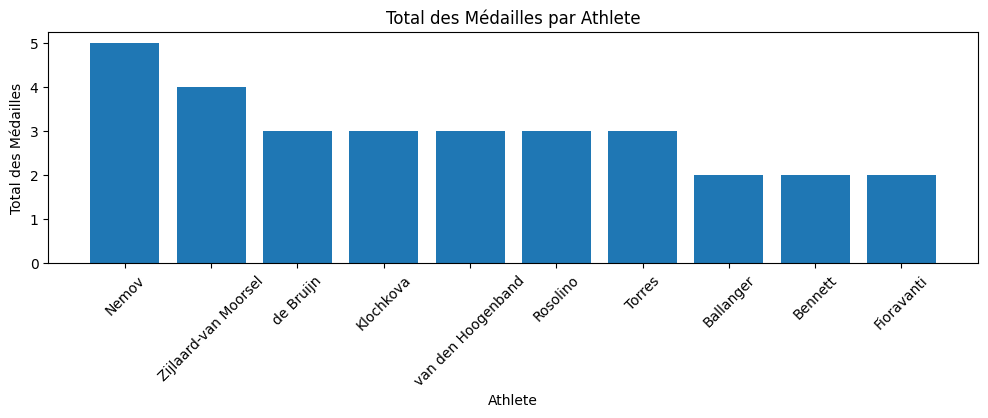

In [11]:
# Récupérer les données, les transformer si nécessaire, puis afficher sous forme de tableau et/ou d'un graphique

classementAthletesIndividuel = requete_vers_dataframe(conn,f""" SELECT  A.idAthlete, A.prenomAthlete, A.nomAthlete,
SUM(CASE WHEN PI.Medaille = 'Gold' THEN 1 ELSE 0 END) AS Gold,
SUM(CASE WHEN PI.Medaille = 'Silver' THEN 1 ELSE 0 END) AS Silver,
SUM(CASE WHEN PI.Medaille = 'Bronze' THEN 1 ELSE 0 END) AS Bronze,
COUNT(PI.Medaille) AS Total 
FROM {SCHEMA}.EVENEMENT E 
INNER JOIN {SCHEMA}.PARTICIPATION_INDIVIDUELLE PI ON PI.idEvent = E.idEvenement
INNER JOIN {SCHEMA}.ATHLETE A ON A.idAthlete = PI.idAthlete
WHERE IDHOTE = '{id_hote}'
GROUP BY A.idAthlete, A.prenomAthlete, A.nomAthlete
ORDER BY Total DESC, Gold DESC, Silver DESC, Bronze DESC, nomathlete, 
prenomathlete, idathlete""")
athleteTop10Individuel = classementAthletesIndividuel.iloc[0:10]

print(athleteTop10Individuel)      #afficher les 10 premieres lignes de la dataFrame

plt.figure(figsize=(12, 3))
plt.bar(athleteTop10Individuel['NOMATHLETE'], athleteTop10Individuel['TOTAL'])
plt.xlabel('Athlete')
plt.ylabel('Total des Médailles')
plt.title('Total des Médailles par Athlete')
plt.xticks(rotation=45)
plt.show()

##### Répartition par NOC

   NOC  GOLD  SILVER  BRONZE  TOTAL
0  RUS    24      23      25     72
1  USA    24      17      24     65
2  CHN    21      10      12     43
3  GER     6      14      14     34
4  AUS     7      15      10     32
5  FRA     9      11       8     28
6  CUB    10       9       5     24
7  ITA     9       5       9     23
8  KOR     6       8       7     21
9  GBR     9       5       5     19


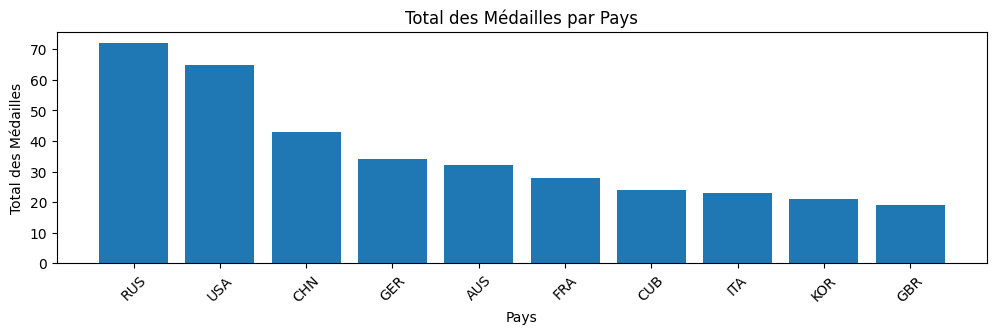

In [12]:
## Récupérer les données, les transformer si nécessaire, puis afficher sous forme de tableau et/ou d'un graphique
classementNocIndividuel = requete_vers_dataframe(conn,f"""SELECT PI.NOC,
SUM(CASE WHEN PI.Medaille = 'Gold' THEN 1 ELSE 0 END) AS Gold,
SUM(CASE WHEN PI.Medaille = 'Silver' THEN 1 ELSE 0 END) AS Silver,
SUM(CASE WHEN PI.Medaille = 'Bronze' THEN 1 ELSE 0 END) AS Bronze,
COUNT(PI.Medaille) AS Total 
FROM {SCHEMA}.EVENEMENT E
INNER JOIN {SCHEMA}.PARTICIPATION_INDIVIDUELLE PI ON PI.idEvent = E.idEvenement
WHERE IDHOTE = '{id_hote}'
GROUP BY PI.NOC
ORDER BY Total DESC, Gold DESC, Silver DESC, Bronze DESC, noc""")
NOCTop10Individuel = classementNocIndividuel.iloc[0:10]

print(NOCTop10Individuel)      #afficher les 10 premieres lignes de la dataFrame

plt.figure(figsize=(12, 3))
plt.bar(NOCTop10Individuel['NOC'], NOCTop10Individuel['TOTAL'])
plt.xlabel('Pays')
plt.ylabel('Total des Médailles')
plt.title('Total des Médailles par Pays')
plt.xticks(rotation=45)
plt.show()

#### Médailles par équipes (épreuves par équipe)

##### Tableau du TOP 10 par équipe

   IDATHLETE PRENOMATHLETE         NOMATHLETE  GOLD  SILVER  BRONZE  TOTAL
0      51217         Jenny           Thompson     3       0       0      3
1      45230       Michael               Klim     2       1       0      3
2      93280           Ian             Thorpe     2       1       0      3
3      50021          Olga         Brusnikina     2       0       0      2
4      92674      Georgeta  Damian-Andrunache     2       0       0      2
5       9879        Birgit    Fischer-Schmidt     2       0       0      2
6      39501         Doina              Ignat     2       0       0      2
7      10072        Zoltán           Kammerer     2       0       0      2
8      50025        Mariya          Kiselyova     2       0       0      2
9      93273          Todd            Pearson     2       0       0      2


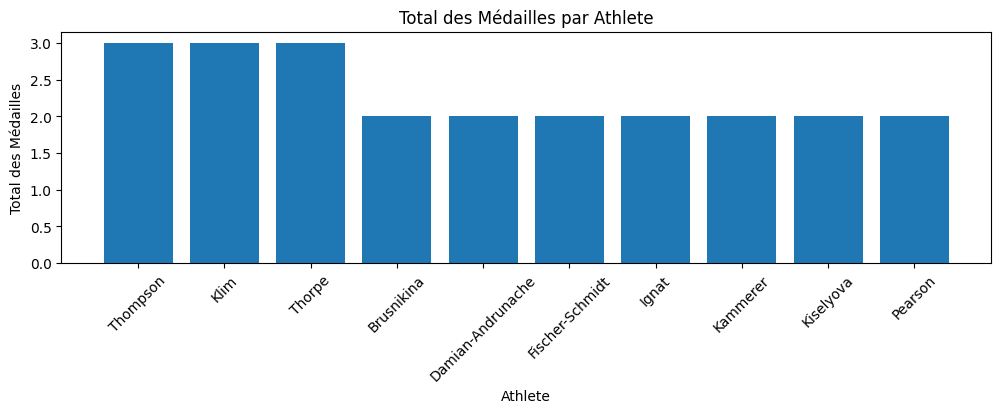

In [13]:
# Récupérer les données, les transformer si nécessaire, puis afficher sous forme de tableau et/ou d'un graphique

classementAthletesEquipe = requete_vers_dataframe(conn,f""" SELECT  A.idAthlete, A.prenomAthlete, A.nomAthlete,
SUM(CASE WHEN PE.Medaille = 'Gold' THEN 1 ELSE 0 END) AS Gold,
SUM(CASE WHEN PE.Medaille = 'Silver' THEN 1 ELSE 0 END) AS Silver,
SUM(CASE WHEN PE.Medaille = 'Bronze' THEN 1 ELSE 0 END) AS Bronze,
COUNT(PE.Medaille) AS Total 
FROM {SCHEMA}.EVENEMENT E
INNER JOIN {SCHEMA}.PARTICIPATION_EQUIPE PE ON PE.idEvenement = E.idEvenement
INNER JOIN {SCHEMA}.COMPOSITION_EQUIPE CE ON CE.idEquipe = PE.idEquipe
INNER JOIN {SCHEMA}.ATHLETE A ON A.idAthlete = CE.idAthlete
WHERE IDHOTE = '{id_hote}'
GROUP BY A.idAthlete, A.prenomAthlete, A.nomAthlete
ORDER BY Total DESC, Gold DESC, Silver DESC, Bronze DESC, nomathlete, 
prenomathlete, idathlete""")
athleteTop10Equipe = classementAthletesEquipe.iloc[0:10]

print(athleteTop10Equipe)      #afficher les 10 premieres lignes de la dataFrame

plt.figure(figsize=(12, 3))
plt.bar(athleteTop10Equipe['NOMATHLETE'], athleteTop10Equipe['TOTAL'])
plt.xlabel('Athlete')
plt.ylabel('Total des Médailles')
plt.title('Total des Médailles par Athlete')
plt.xticks(rotation=45)
plt.show()

##### Répartition par NOC

   NOC  GOLD  SILVER  BRONZE  TOTAL
0  USA    13       7       8     28
1  AUS     9      10       7     26
2  GER     7       3      12     22
3  RUS     8       5       4     17
4  CHN     7       6       2     15
5  ITA     4       3       4     11
6  FRA     4       3       3     10
7  GBR     2       5       2      9
8  NED     1       6       2      9
9  BRA     0       3       6      9


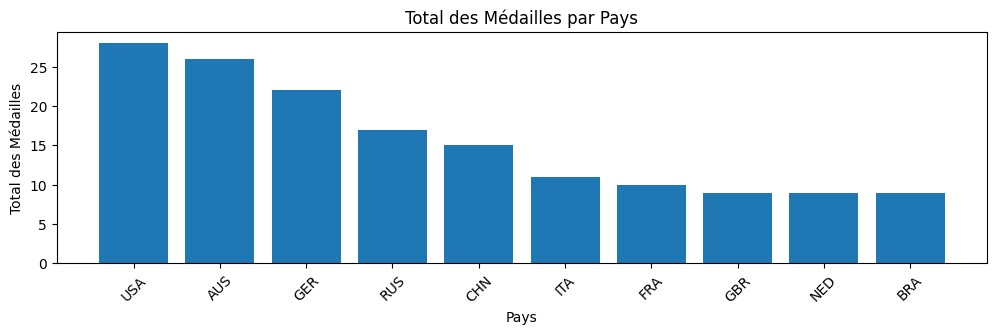

In [14]:
# Récupérer les données, les transformer si nécessaire, puis afficher sous forme de tableau et/ou d'un graphique

classementNocEquipe = requete_vers_dataframe(conn,f"""SELECT EQ.NOC,
SUM(CASE WHEN PE.Medaille = 'Gold' THEN 1 ELSE 0 END) AS Gold,
SUM(CASE WHEN PE.Medaille = 'Silver' THEN 1 ELSE 0 END) AS Silver,
SUM(CASE WHEN PE.Medaille = 'Bronze' THEN 1 ELSE 0 END) AS Bronze,
COUNT(PE.Medaille) AS Total 
FROM {SCHEMA}.EVENEMENT E 
INNER JOIN {SCHEMA}.PARTICIPATION_EQUIPE PE ON PE.idEvenement = E.idEvenement
INNER JOIN {SCHEMA}.EQUIPE EQ ON PE.idEquipe = EQ.idEquipe
WHERE IDHOTE = '{id_hote}'
GROUP BY EQ.NOC
ORDER BY Total DESC, Gold DESC, Silver DESC, Bronze DESC, eq.noc""")
NOCTop10Equipe = classementNocEquipe.iloc[0:10]

print(NOCTop10Equipe)      #afficher les 10 premieres lignes de la dataFrame

plt.figure(figsize=(12, 3))
plt.bar(NOCTop10Equipe['NOC'], NOCTop10Equipe['TOTAL'])
plt.xlabel('Pays')
plt.ylabel('Total des Médailles')
plt.title('Total des Médailles par Pays')
plt.xticks(rotation=45)
plt.show()

## Partie modification des données

On décide d'ajouter à l'édition des JO étudiée une nouvelle épreuve : le tir à l'arc à poulies. C'est une épreuve de tir à l'arc (*archery*, code `ARC`), qui se fait soit en arc à poulies homme (individuel ou équipe, mais on ne traitera que le cas individuel), soit arc à poulies femmes (individuel ou équipe). Les noms à utiliser pour les événements seront :

- *Compound individual, Men*
- *Compound individual, Women*

Pour simuler les résultats, vous utiliserez les résultats de l'épreuve de [tir à l'arc classique des JO de 2020 en individuel homme](https://www.olympedia.org/results/18000492) en faisant comme s'il s'agissait d'arc à poulies : les athlètes existent déjà dans la base, vous devez maintenant faire en sorte d'ajouter à la base les différents résultats.

Avant de réaliser les modifications, affichez le tableau des médailles individuelles pour l'Italie

In [272]:
# On donne ici l'exemple de comment ajouter un événement. On a stocké dans id_hote l'identifiant des JO sur lesquels on travaille
with Connexion(login=conn['login'], password=conn['password']) as connexion:  # Démarre une nouvelle connexion
    # On démarre une nouvelle transaction
    connexion.begin()
    # On ouvre un curseur, qui est une sorte de pointeur vers une table de résultats
    curseur = connexion.cursor()
    # On passe la requête paramétrée et les paramètres (s'il y en a) au curseur
    curseur.execute(f"SELECT MAX(IDEVENEMENT) FROM {SCHEMA}.EVENEMENT")
    # S'il n'y a pas d'erreur, on peut demander à récupérer les résultats : 
    # - curseur.fetchone() récupère la ligne sur laquelle pointe le curseur, renvoie le résultat sous forme de tuple, et avance à la ligne suivante (si elle existe)
    # - curseur.fetchall() boucle sur toutes les lignes restantes et renvoie une liste de tuples, ou une liste vide s'il n'y a plus de résultats
    # - curseur.fetchmany(nb) renvoie les résultats des nb lignes suivantes sous forme de liste de tuples
    idev = curseur.fetchone()[0]  # Renvoie un tuple, on veut le premier élément du tuple
    idev += 1
    print(idev)
    curseur.execute(f"INSERT INTO {SCHEMA}.EVENEMENT VALUES(:idev, :nomev, :statutev, :codedisc, :idhote)", {'idev': idev, 'nomev': 'Compound Individual, Men', 'statutev': 'Olympic', 'codedisc': 'ARC', 'idhote': id_hote})
    connexion.commit()  #On commit (# On annule, ce qui est au dessus est pour l'exemple, vous devrez utiliser commit() pour valider la transaction.)

90016775


In [273]:
# Afficher le tableau des médailles individuelles de l'Italie
classementNocIndividuel[classementNocIndividuel['NOC'] == 'ITA']

,NOC,GOLD,SILVER,BRONZE,TOTAL
7,ITA,9,5,9,23


### Qualifications [Bonus]

Le round de qualifications en tir à l'arc à poulie est assez similaire au tir à l'arc classique, avec comme différence qu'il n'y a pas de "X", ils comptent comme des 10 pour départager. En utilisant le tableau des résultats de qualifications, faites en sorte que votre tableau de bord insère les données dans la base puis les affiche.

In [274]:
# Faire ici l'insertion des données
with Connexion(login=conn['login'], password=conn['password']) as connexion: 
    connexion.begin()
    curseur = connexion.cursor()
    id_manche = 1
    manche_resultat = id_manche
    curseur.execute(f"INSERT INTO manche VALUES ({idev}, {id_manche} , 'Ranking Round' )")
    # Ajout des libelle correspondants aux résultats 
    curseur.execute(f"INSERT INTO resultat_libelle(idevenement, idmanche, libelle1, libelle2, libelle3, libelle4) VALUES ({idev}, {id_manche} , 'Points', 'Targets Hit', '10s', '9s' )")

    #Ajout des résultats
    curseur.execute(f"INSERT INTO resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4) VALUES ((SELECT COUNT(*)+1 FROM resultat),{idev}, {id_manche}, '665', '72', '27', '6')")
    curseur.execute(f"INSERT INTO performance_individuelle VALUES ({idev}, {id_manche}, 1973, '665', 'Points', null, (SELECT COUNT(*) FROM resultat))")

    curseur.execute(f"INSERT INTO resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4) VALUES ((SELECT COUNT(*)+1 FROM resultat),{idev}, {id_manche}, '660', '72', '26', '5')")
    curseur.execute(f"INSERT INTO performance_individuelle VALUES ({idev}, {id_manche}, 1978, '660', 'Points', null, (SELECT COUNT(*) FROM resultat))")

    curseur.execute(f"INSERT INTO resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4) VALUES ((SELECT COUNT(*)+1 FROM resultat),{idev}, {id_manche}, '655', '72', '27', '7')")
    curseur.execute(f"INSERT INTO performance_individuelle VALUES ({idev}, {id_manche}, 83168, '655', 'Points', null, (SELECT COUNT(*) FROM resultat))")

    curseur.execute(f"INSERT INTO resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4) VALUES ((SELECT COUNT(*)+1 FROM resultat),{idev}, {id_manche}, '651', '72', '23', '9')")
    curseur.execute(f"INSERT INTO performance_individuelle VALUES ({idev}, {id_manche}, 2253, '651', 'Points', null, (SELECT COUNT(*) FROM resultat))")

    curseur.execute(f"INSERT INTO resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4) VALUES ((SELECT COUNT(*)+1 FROM resultat),{idev}, {id_manche}, '649', '72', '22', '6')")
    curseur.execute(f"INSERT INTO performance_individuelle VALUES ({idev}, {id_manche}, 2187, '649', 'Points', null, (SELECT COUNT(*) FROM resultat))")

    curseur.execute(f"INSERT INTO resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4) VALUES ((SELECT COUNT(*)+1 FROM resultat),{idev}, {id_manche}, '646', '72', '25', '8')")
    curseur.execute(f"INSERT INTO performance_individuelle VALUES ({idev}, {id_manche}, 2143, '646', 'Points', null, (SELECT COUNT(*) FROM resultat))")

    curseur.execute(f"INSERT INTO resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4) VALUES ((SELECT COUNT(*)+1 FROM resultat),{idev}, {id_manche}, '643', '72', '21', '8')")
    curseur.execute(f"INSERT INTO performance_individuelle VALUES ({idev}, {id_manche}, 83205, '643', 'Points', null, (SELECT COUNT(*) FROM resultat))")

    curseur.execute(f"INSERT INTO resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4) VALUES ((SELECT COUNT(*)+1 FROM resultat),{idev}, {id_manche}, '642', '72', '20', '6')")
    curseur.execute(f"INSERT INTO performance_individuelle VALUES ({idev}, {id_manche}, 300, '642', 'Points', null, (SELECT COUNT(*) FROM resultat))")

    curseur.execute(f"INSERT INTO resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4) VALUES ((SELECT COUNT(*)+1 FROM resultat),{idev}, {id_manche}, '641', '72', '20', '8')")
    curseur.execute(f"INSERT INTO performance_individuelle VALUES ({idev}, {id_manche}, 80491, '641', 'Points', null, (SELECT COUNT(*) FROM resultat))")

    curseur.execute(f"INSERT INTO resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4) VALUES ((SELECT COUNT(*)+1 FROM resultat),{idev}, {id_manche}, '640', '72', '25', '6')")
    curseur.execute(f"INSERT INTO performance_individuelle VALUES ({idev}, {id_manche}, 80471, '640', 'Points', null, (SELECT COUNT(*) FROM resultat))")

    curseur.execute(f"INSERT INTO resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4) VALUES ((SELECT COUNT(*)+1 FROM resultat),{idev}, {id_manche}, '639', '72', '25', '4')")
    curseur.execute(f"INSERT INTO performance_individuelle VALUES ({idev}, {id_manche}, 500, '639', 'Points', null, (SELECT COUNT(*) FROM resultat))")

    curseur.execute(f"INSERT INTO resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4) VALUES ((SELECT COUNT(*)+1 FROM resultat),{idev}, {id_manche}, '638', '71', '24', '5')")
    curseur.execute(f"INSERT INTO performance_individuelle VALUES ({idev}, {id_manche}, 83175, '638', 'Points', null, (SELECT COUNT(*) FROM resultat))")

    curseur.execute(f"INSERT INTO resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4) VALUES ((SELECT COUNT(*)+1 FROM resultat),{idev}, {id_manche}, '637', '72', '19', '7')")
    curseur.execute(f"INSERT INTO performance_individuelle VALUES ({idev}, {id_manche}, 83196, '637', 'Points', null, (SELECT COUNT(*) FROM resultat))")

    curseur.execute(f"INSERT INTO resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4) VALUES ((SELECT COUNT(*)+1 FROM resultat),{idev}, {id_manche}, '636', '72', '23', '5')")
    curseur.execute(f"INSERT INTO performance_individuelle VALUES ({idev}, {id_manche}, 83195, '636', 'Points', null, (SELECT COUNT(*) FROM resultat))")

    curseur.execute(f"INSERT INTO resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4) VALUES ((SELECT COUNT(*)+1 FROM resultat),{idev}, {id_manche}, '635', '72', '22', '7')")
    curseur.execute(f"INSERT INTO performance_individuelle VALUES ({idev}, {id_manche}, 83165, '635', 'Points', null, (SELECT COUNT(*) FROM resultat))")

    curseur.execute(f"INSERT INTO resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4) VALUES ((SELECT COUNT(*)+1 FROM resultat),{idev}, {id_manche}, '635', '72', '20', '6')")
    curseur.execute(f"INSERT INTO performance_individuelle VALUES ({idev}, {id_manche}, 394, '635', 'Points', null, (SELECT COUNT(*) FROM resultat))")

    curseur.execute(f"INSERT INTO resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4) VALUES ((SELECT COUNT(*)+1 FROM resultat),{idev}, {id_manche}, '635', '72', '15', '2')")
    curseur.execute(f"INSERT INTO performance_individuelle VALUES ({idev}, {id_manche}, 2110, '635', 'Points', null, (SELECT COUNT(*) FROM resultat))")

    curseur.execute(f"INSERT INTO resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4) VALUES ((SELECT COUNT(*)+1 FROM resultat),{idev}, {id_manche}, '634', '72', '23', '10')")
    curseur.execute(f"INSERT INTO performance_individuelle VALUES ({idev}, {id_manche}, 1918, '634', 'Points', null, (SELECT COUNT(*) FROM resultat))")

    curseur.execute(f"INSERT INTO resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4) VALUES ((SELECT COUNT(*)+1 FROM resultat),{idev}, {id_manche}, '634', '72', '16', '3')")
    curseur.execute(f"INSERT INTO performance_individuelle VALUES ({idev}, {id_manche}, 1921, '634', 'Points', null, (SELECT COUNT(*) FROM resultat))")

    curseur.execute(f"INSERT INTO resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4) VALUES ((SELECT COUNT(*)+1 FROM resultat),{idev}, {id_manche}, '634', '71', '21', '7')")
    curseur.execute(f"INSERT INTO performance_individuelle VALUES ({idev}, {id_manche}, 2035, '634', 'Points', null, (SELECT COUNT(*) FROM resultat))")

    curseur.execute(f"INSERT INTO resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4) VALUES ((SELECT COUNT(*)+1 FROM resultat),{idev}, {id_manche}, '633', '72', '15', '6')")
    curseur.execute(f"INSERT INTO performance_individuelle VALUES ({idev}, {id_manche}, 83185, '633', 'Points', null, (SELECT COUNT(*) FROM resultat))")

    curseur.execute(f"INSERT INTO resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4) VALUES ((SELECT COUNT(*)+1 FROM resultat),{idev}, {id_manche}, '632', '72', '23', '13')")
    curseur.execute(f"INSERT INTO performance_individuelle VALUES ({idev}, {id_manche}, 80476, '632', 'Points', null, (SELECT COUNT(*) FROM resultat))")

    curseur.execute(f"INSERT INTO resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4) VALUES ((SELECT COUNT(*)+1 FROM resultat),{idev}, {id_manche}, '632', '72', '23', '4')")
    curseur.execute(f"INSERT INTO performance_individuelle VALUES ({idev}, {id_manche}, 1953, '632', 'Points', null, (SELECT COUNT(*) FROM resultat))")

    curseur.execute(f"INSERT INTO resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4) VALUES ((SELECT COUNT(*)+1 FROM resultat),{idev}, {id_manche}, '632', '72', '22', '7')")
    curseur.execute(f"INSERT INTO performance_individuelle VALUES ({idev}, {id_manche}, 83202, '632', 'Points', null, (SELECT COUNT(*) FROM resultat))")

    curseur.execute(f"INSERT INTO resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4) VALUES ((SELECT COUNT(*)+1 FROM resultat),{idev}, {id_manche}, '632', '72', '18', '3')")
    curseur.execute(f"INSERT INTO performance_individuelle VALUES ({idev}, {id_manche}, 80488, '632', 'Points', null, (SELECT COUNT(*) FROM resultat))")

    curseur.execute(f"INSERT INTO resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4) VALUES ((SELECT COUNT(*)+1 FROM resultat),{idev}, {id_manche}, '631', '72', '19', '3')")
    curseur.execute(f"INSERT INTO performance_individuelle VALUES ({idev}, {id_manche}, 83199, '631', 'Points', null, (SELECT COUNT(*) FROM resultat))")

    curseur.execute(f"INSERT INTO resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4) VALUES ((SELECT COUNT(*)+1 FROM resultat),{idev}, {id_manche}, '631', '72', '15', '4')")
    curseur.execute(f"INSERT INTO performance_individuelle VALUES ({idev}, {id_manche}, 302, '631', 'Points', null, (SELECT COUNT(*) FROM resultat))")

    curseur.execute(f"INSERT INTO resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4) VALUES ((SELECT COUNT(*)+1 FROM resultat),{idev}, {id_manche}, '629', '72', '20', '7')")
    curseur.execute(f"INSERT INTO performance_individuelle VALUES ({idev}, {id_manche}, 83190, '629', 'Points', null, (SELECT COUNT(*) FROM resultat))")

    curseur.execute(f"INSERT INTO resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4) VALUES ((SELECT COUNT(*)+1 FROM resultat),{idev}, {id_manche}, '627', '72', '23', '4')")
    curseur.execute(f"INSERT INTO performance_individuelle VALUES ({idev}, {id_manche}, 83176, '627', 'Points', null, (SELECT COUNT(*) FROM resultat))")

    curseur.execute(f"INSERT INTO resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4) VALUES ((SELECT COUNT(*)+1 FROM resultat),{idev}, {id_manche}, '627', '72', '19', '6')")
    curseur.execute(f"INSERT INTO performance_individuelle VALUES ({idev}, {id_manche}, 1919, '627', 'Points', null, (SELECT COUNT(*) FROM resultat))")

    curseur.execute(f"INSERT INTO resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4) VALUES ((SELECT COUNT(*)+1 FROM resultat),{idev}, {id_manche}, '627', '72', '18', '1')")
    curseur.execute(f"INSERT INTO performance_individuelle VALUES ({idev}, {id_manche}, 2235, '627', 'Points', null, (SELECT COUNT(*) FROM resultat))")

    curseur.execute(f"INSERT INTO resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4) VALUES ((SELECT COUNT(*)+1 FROM resultat),{idev}, {id_manche}, '626', '72', '16', '6')")
    curseur.execute(f"INSERT INTO performance_individuelle VALUES ({idev}, {id_manche}, 83194, '626', 'Points', null, (SELECT COUNT(*) FROM resultat))")

    curseur.execute(f"INSERT INTO resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4) VALUES ((SELECT COUNT(*)+1 FROM resultat),{idev}, {id_manche}, '625', '72', '16', '8')")
    curseur.execute(f"INSERT INTO performance_individuelle VALUES ({idev}, {id_manche}, 83171, '625', 'Points', null, (SELECT COUNT(*) FROM resultat))")

    curseur.execute(f"INSERT INTO resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4) VALUES ((SELECT COUNT(*)+1 FROM resultat),{idev}, {id_manche}, '624', '72', '15', '4')")
    curseur.execute(f"INSERT INTO performance_individuelle VALUES ({idev}, {id_manche}, 2111, '624', 'Points', null, (SELECT COUNT(*) FROM resultat))")

    curseur.execute(f"INSERT INTO resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4) VALUES ((SELECT COUNT(*)+1 FROM resultat),{idev}, {id_manche}, '623', '72', '14', '3')")
    curseur.execute(f"INSERT INTO performance_individuelle VALUES ({idev}, {id_manche}, 80501, '623', 'Points', null, (SELECT COUNT(*) FROM resultat))")

    curseur.execute(f"INSERT INTO resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4) VALUES ((SELECT COUNT(*)+1 FROM resultat),{idev}, {id_manche}, '622', '72', '19', '6')")
    curseur.execute(f"INSERT INTO performance_individuelle VALUES ({idev}, {id_manche}, 440, '622', 'Points', null, (SELECT COUNT(*) FROM resultat))")

    curseur.execute(f"INSERT INTO resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4) VALUES ((SELECT COUNT(*)+1 FROM resultat),{idev}, {id_manche}, '622', '72', '17', '5')")
    curseur.execute(f"INSERT INTO performance_individuelle VALUES ({idev}, {id_manche}, 380, '622', 'Points', null, (SELECT COUNT(*) FROM resultat))")

    curseur.execute(f"INSERT INTO resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4) VALUES ((SELECT COUNT(*)+1 FROM resultat),{idev}, {id_manche}, '619', '72', '16', '6')")
    curseur.execute(f"INSERT INTO performance_individuelle VALUES ({idev}, {id_manche}, 401, '619', 'Points', null, (SELECT COUNT(*) FROM resultat))")

    curseur.execute(f"INSERT INTO resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4) VALUES ((SELECT COUNT(*)+1 FROM resultat),{idev}, {id_manche}, '618', '72', '23', '8')")
    curseur.execute(f"INSERT INTO performance_individuelle VALUES ({idev}, {id_manche}, 2108, '618', 'Points', null, (SELECT COUNT(*) FROM resultat))")

    curseur.execute(f"INSERT INTO resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4) VALUES ((SELECT COUNT(*)+1 FROM resultat),{idev}, {id_manche}, '617', '72', '14', '3')")
    curseur.execute(f"INSERT INTO performance_individuelle VALUES ({idev}, {id_manche}, 2198, '617', 'Points', null, (SELECT COUNT(*) FROM resultat))")

    curseur.execute(f"INSERT INTO resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4) VALUES ((SELECT COUNT(*)+1 FROM resultat),{idev}, {id_manche}, '616', '72', '21', '7')")
    curseur.execute(f"INSERT INTO performance_individuelle VALUES ({idev}, {id_manche}, 80478, '616', 'Points', null, (SELECT COUNT(*) FROM resultat))")

    curseur.execute(f"INSERT INTO resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4) VALUES ((SELECT COUNT(*)+1 FROM resultat),{idev}, {id_manche}, '616', '72', '14', '4')")
    curseur.execute(f"INSERT INTO performance_individuelle VALUES ({idev}, {id_manche}, 83189, '616', 'Points', null, (SELECT COUNT(*) FROM resultat))")

    curseur.execute(f"INSERT INTO resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4) VALUES ((SELECT COUNT(*)+1 FROM resultat),{idev}, {id_manche}, '615', '72', '11', '2')")
    curseur.execute(f"INSERT INTO performance_individuelle VALUES ({idev}, {id_manche}, 83201, '615', 'Points', null, (SELECT COUNT(*) FROM resultat))")

    curseur.execute(f"INSERT INTO resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4) VALUES ((SELECT COUNT(*)+1 FROM resultat),{idev}, {id_manche}, '614', '72', '12', '1')")
    curseur.execute(f"INSERT INTO performance_individuelle VALUES ({idev}, {id_manche}, 1942, '614', 'Points', null, (SELECT COUNT(*) FROM resultat))")

    curseur.execute(f"INSERT INTO resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4) VALUES ((SELECT COUNT(*)+1 FROM resultat),{idev}, {id_manche}, '613', '72', '19', '6')")
    curseur.execute(f"INSERT INTO performance_individuelle VALUES ({idev}, {id_manche}, 83178, '613', 'Points', null, (SELECT COUNT(*) FROM resultat))")

    curseur.execute(f"INSERT INTO resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4) VALUES ((SELECT COUNT(*)+1 FROM resultat),{idev}, {id_manche}, '613', '72', '15', '5')")
    curseur.execute(f"INSERT INTO performance_individuelle VALUES ({idev}, {id_manche}, 83177, '613', 'Points', null, (SELECT COUNT(*) FROM resultat))")

    curseur.execute(f"INSERT INTO resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4) VALUES ((SELECT COUNT(*)+1 FROM resultat),{idev}, {id_manche}, '613', '72', '13', '7')")
    curseur.execute(f"INSERT INTO performance_individuelle VALUES ({idev}, {id_manche}, 2040, '613', 'Points', null, (SELECT COUNT(*) FROM resultat))")

    curseur.execute(f"INSERT INTO resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4) VALUES ((SELECT COUNT(*)+1 FROM resultat),{idev}, {id_manche}, '607', '71', '15', '2')")
    curseur.execute(f"INSERT INTO performance_individuelle VALUES ({idev}, {id_manche}, 83179, '607', 'Points', null, (SELECT COUNT(*) FROM resultat))")

    curseur.execute(f"INSERT INTO resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4) VALUES ((SELECT COUNT(*)+1 FROM resultat),{idev}, {id_manche}, '606', '72', '16', '6')")
    curseur.execute(f"INSERT INTO performance_individuelle VALUES ({idev}, {id_manche}, 83184, '606', 'Points', null, (SELECT COUNT(*) FROM resultat))")

    curseur.execute(f"INSERT INTO resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4) VALUES ((SELECT COUNT(*)+1 FROM resultat),{idev}, {id_manche}, '604', '72', '16', '4')")
    curseur.execute(f"INSERT INTO performance_individuelle VALUES ({idev}, {id_manche}, 83164, '604', 'Points', null, (SELECT COUNT(*) FROM resultat))")

    curseur.execute(f"INSERT INTO resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4) VALUES ((SELECT COUNT(*)+1 FROM resultat),{idev}, {id_manche}, '603', '72', '15', '5')")
    curseur.execute(f"INSERT INTO performance_individuelle VALUES ({idev}, {id_manche}, 304, '603', 'Points', null, (SELECT COUNT(*) FROM resultat))")

    curseur.execute(f"INSERT INTO resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4) VALUES ((SELECT COUNT(*)+1 FROM resultat),{idev}, {id_manche}, '603', '72', '12', '6')")
    curseur.execute(f"INSERT INTO performance_individuelle VALUES ({idev}, {id_manche}, 471, '603', 'Points', null, (SELECT COUNT(*) FROM resultat))")

    curseur.execute(f"INSERT INTO resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4) VALUES ((SELECT COUNT(*)+1 FROM resultat),{idev}, {id_manche}, '603', '72', '12', '4')")
    curseur.execute(f"INSERT INTO performance_individuelle VALUES ({idev}, {id_manche}, 80486, '603', 'Points', null, (SELECT COUNT(*) FROM resultat))")

    curseur.execute(f"INSERT INTO resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4) VALUES ((SELECT COUNT(*)+1 FROM resultat),{idev}, {id_manche}, '596', '72', '13', '2')")
    curseur.execute(f"INSERT INTO performance_individuelle VALUES ({idev}, {id_manche}, 80495, '596', 'Points', null, (SELECT COUNT(*) FROM resultat))")

    curseur.execute(f"INSERT INTO resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4) VALUES ((SELECT COUNT(*)+1 FROM resultat),{idev}, {id_manche}, '596', '72', '7', '1')")
    curseur.execute(f"INSERT INTO performance_individuelle VALUES ({idev}, {id_manche}, 346, '596', 'Points', null, (SELECT COUNT(*) FROM resultat))")

    curseur.execute(f"INSERT INTO resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4) VALUES ((SELECT COUNT(*)+1 FROM resultat),{idev}, {id_manche}, '596', '71', '10', '3')")
    curseur.execute(f"INSERT INTO performance_individuelle VALUES ({idev}, {id_manche}, 83180, '596', 'Points', null, (SELECT COUNT(*) FROM resultat))")

    curseur.execute(f"INSERT INTO resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4) VALUES ((SELECT COUNT(*)+1 FROM resultat),{idev}, {id_manche}, '595', '72', '9', '2')")
    curseur.execute(f"INSERT INTO performance_individuelle VALUES ({idev}, {id_manche}, 80481, '595', 'Points', null, (SELECT COUNT(*) FROM resultat))")

    curseur.execute(f"INSERT INTO resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4) VALUES ((SELECT COUNT(*)+1 FROM resultat),{idev}, {id_manche}, '588', '72', '8', '2')")
    curseur.execute(f"INSERT INTO performance_individuelle VALUES ({idev}, {id_manche}, 80484, '588', 'Points', null, (SELECT COUNT(*) FROM resultat))")

    curseur.execute(f"INSERT INTO resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4) VALUES ((SELECT COUNT(*)+1 FROM resultat),{idev}, {id_manche}, '572', '72', '9', '4')")
    curseur.execute(f"INSERT INTO performance_individuelle VALUES ({idev}, {id_manche}, 2075, '572', 'Points', null, (SELECT COUNT(*) FROM resultat))")

    curseur.execute(f"INSERT INTO resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4) VALUES ((SELECT COUNT(*)+1 FROM resultat),{idev}, {id_manche}, '556', '72', '7', '4')")
    curseur.execute(f"INSERT INTO performance_individuelle VALUES ({idev}, {id_manche}, 80483, '556', 'Points', null, (SELECT COUNT(*) FROM resultat))")

    curseur.execute(f"INSERT INTO resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4) VALUES ((SELECT COUNT(*)+1 FROM resultat),{idev}, {id_manche}, '546', '72', '11', '4')")
    curseur.execute(f"INSERT INTO performance_individuelle VALUES ({idev}, {id_manche}, 83206, '546', 'Points', null, (SELECT COUNT(*) FROM resultat))")

    curseur.execute(f"INSERT INTO resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4) VALUES ((SELECT COUNT(*)+1 FROM resultat),{idev}, {id_manche}, '537', '72', '10', '2')")
    curseur.execute(f"INSERT INTO performance_individuelle VALUES ({idev}, {id_manche}, 83173, '537', 'Points', null, (SELECT COUNT(*) FROM resultat))")

    curseur.execute(f"INSERT INTO resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4) VALUES ((SELECT COUNT(*)+1 FROM resultat),{idev}, {id_manche}, '500', '72', '4', '0')")
    curseur.execute(f"INSERT INTO performance_individuelle VALUES ({idev}, {id_manche}, 1957, '500', 'Points', null, (SELECT COUNT(*) FROM resultat))")

    curseur.execute(f"INSERT INTO resultat(idresultat, idevenement, idmanche, resultat1, resultat2, resultat3, resultat4) VALUES ((SELECT COUNT(*)+1 FROM resultat),{idev}, {id_manche}, '419', '71', '3', '1')")
    curseur.execute(f"INSERT INTO performance_individuelle VALUES ({idev}, {id_manche}, 80467, '419', 'Points', null, (SELECT COUNT(*) FROM resultat))")



    connexion.commit()

In [275]:
# Faire ici l'affichage du tableau de résultat des qualifications
libelle = requete_vers_dataframe(conn, f"""SELECT libelle1, libelle2, libelle3, libelle4, libelle5 FROM resultat_libelle
                                            WHERE idevenement = {idev} AND idmanche = {id_manche}""")

ranking = requete_vers_dataframe(conn, f"""
SELECT DISTINCT nomathlete, prenomathlete, noc, resultat1, resultat2, resultat3, resultat4, resultat5 
FROM performance_individuelle pi
INNER JOIN resultat r ON r.idresultat = pi.resultat_detaille
INNER JOIN athlete a ON a.idathlete = pi.idathlete
INNER JOIN participation_individuelle ppi ON ppi.idathlete = a.idathlete
INNER JOIN evenement e ON e.idevenement = ppi.idevent
WHERE pi.idevenement = {idev} AND pi.idmanche = {id_manche} AND idhote = {id_hote}
ORDER BY TO_NUMBER(resultat1) DESC, TO_NUMBER(resultat2) DESC, TO_NUMBER(resultat3) DESC, TO_NUMBER(resultat4)DESC, TO_NUMBER(resultat5)DESC, 
nomathlete, prenomathlete, noc
""")

#On ajuste le nombre de colonne en fonction nu nombre de libelle (on part du principe qu'il y a autant d'infos que de libelle)
colonnes = libelle.iloc[0].tolist()
for i in reversed(range(len(colonnes))):
    if colonnes[i] is None:
        colonnes.pop(i)
        ranking.drop(columns=[ranking.columns[i + 3]], inplace=True)

#On renommes les colonnes du dataframe en fonction des libelles
ranking.columns = ['NOMATHLETE', 'PRENOMATHLETE', 'NOC'] + colonnes

print(ranking)

    NOMATHLETE PRENOMATHLETE  NOC Points Targets Hit 10s 9s
0      Yong-Ho          Jang  KOR    665          72  27  6
1      Gyo-Mun            Oh  KOR    660          72  26  5
2   Cheong-Tae           Kim  KOR    655          72  27  7
3        White           Rod  USA    651          72  23  9
4    Zabrodsky     Stanislav  KAZ    649          72  22  6
..         ...           ...  ...    ...         ...  .. ..
59       Sayed         Essam  EGY    556          72   7  4
60       Latil      François  VAN    546          72  11  4
61     Bundhun         Yehya  MRI    537          72  10  2
62      Rebelo       Dominic  KEN    500          72   4  0
63       Tupua        Kuresa  ASA    419          71   3  1

[64 rows x 7 columns]


### Première manche [Bonus]

Faire de même ici avec les résultats de la première manche. Pour simplifier, on considérera que les scores sont identiques à ceux en arc classique.

In [276]:
# Faire ici l'insertion des données
id_manche = 2
with Connexion(login=conn['login'], password=conn['password']) as connexion: 
    connexion.begin()
    curseur = connexion.cursor()
    curseur.execute(f"INSERT INTO manche VALUES ({idev}, {id_manche}, 'Round One' )")

    #Récupéré en scrappant le site web
    curseur.execute(f"INSERT INTO match_individuel VALUES ((SELECT COUNT(*) FROM match_individuel), {idev}, {id_manche}, 1973, 80467, '172 – 98')")
    curseur.execute(f"INSERT INTO match_individuel VALUES ((SELECT COUNT(*) FROM match_individuel), {idev}, {id_manche}, 83194, 83171, '165 – 153')")
    curseur.execute(f"INSERT INTO match_individuel VALUES ((SELECT COUNT(*) FROM match_individuel), {idev}, {id_manche}, 2110, 83179, '168 – 147')")
    curseur.execute(f"INSERT INTO match_individuel VALUES ((SELECT COUNT(*) FROM match_individuel), {idev}, {id_manche}, 83184, 394, '157 – 155')")
    curseur.execute(f"INSERT INTO match_individuel VALUES ((SELECT COUNT(*) FROM match_individuel), {idev}, {id_manche}, 300, 80481, '170 – 161')")
    curseur.execute(f"INSERT INTO match_individuel VALUES ((SELECT COUNT(*) FROM match_individuel), {idev}, {id_manche}, 80488, 2198, '171 – 163')")
    curseur.execute(f"INSERT INTO match_individuel VALUES ((SELECT COUNT(*) FROM match_individuel), {idev}, {id_manche}, 80478, 83202, '164 – 160')")
    curseur.execute(f"INSERT INTO match_individuel VALUES ((SELECT COUNT(*) FROM match_individuel), {idev}, {id_manche}, 80491, 83180, '160 – 155')")
    curseur.execute(f"INSERT INTO match_individuel VALUES ((SELECT COUNT(*) FROM match_individuel), {idev}, {id_manche}, 2187, 80483, '166 – 149')")
    curseur.execute(f"INSERT INTO match_individuel VALUES ((SELECT COUNT(*) FROM match_individuel), {idev}, {id_manche}, 83190, 380, '161 – 155')")
    curseur.execute(f"INSERT INTO match_individuel VALUES ((SELECT COUNT(*) FROM match_individuel), {idev}, {id_manche}, 83185, 1942, '166 – 164')")
    curseur.execute(f"INSERT INTO match_individuel VALUES ((SELECT COUNT(*) FROM match_individuel), {idev}, {id_manche}, 83175, 80486, '163 – 160')")
    curseur.execute(f"INSERT INTO match_individuel VALUES ((SELECT COUNT(*) FROM match_individuel), {idev}, {id_manche}, 2253, 83206, '158 – 145')")
    curseur.execute(f"INSERT INTO match_individuel VALUES ((SELECT COUNT(*) FROM match_individuel), {idev}, {id_manche}, 83176, 440, '161 – 155')")
    curseur.execute(f"INSERT INTO match_individuel VALUES ((SELECT COUNT(*) FROM match_individuel), {idev}, {id_manche}, 83178, 2035, '158 – 149')")
    curseur.execute(f"INSERT INTO match_individuel VALUES ((SELECT COUNT(*) FROM match_individuel), {idev}, {id_manche}, 471, 83196, '160 – 156')")
    curseur.execute(f"INSERT INTO match_individuel VALUES ((SELECT COUNT(*) FROM match_individuel), {idev}, {id_manche}, 83168, 83173, '169 – 141')")
    curseur.execute(f"INSERT INTO match_individuel VALUES ((SELECT COUNT(*) FROM match_individuel), {idev}, {id_manche}, 1919, 80501, '163 – 158')")
    curseur.execute(f"INSERT INTO match_individuel VALUES ((SELECT COUNT(*) FROM match_individuel), {idev}, {id_manche}, 1921, 83177, '168 – 158')")
    curseur.execute(f"INSERT INTO match_individuel VALUES ((SELECT COUNT(*) FROM match_individuel), {idev}, {id_manche}, 304, 83195, '154 – 146')")
    curseur.execute(f"INSERT INTO match_individuel VALUES ((SELECT COUNT(*) FROM match_individuel), {idev}, {id_manche}, 2143, 2075, '165 – 146')")
    curseur.execute(f"INSERT INTO match_individuel VALUES ((SELECT COUNT(*) FROM match_individuel), {idev}, {id_manche}, 401, 302, '163 – 161')")
    curseur.execute(f"INSERT INTO match_individuel VALUES ((SELECT COUNT(*) FROM match_individuel), {idev}, {id_manche}, 80476, 83201, '164 – 155')")
    curseur.execute(f"INSERT INTO match_individuel VALUES ((SELECT COUNT(*) FROM match_individuel), {idev}, {id_manche}, 80495, 500, '163 – 161')")
    curseur.execute(f"INSERT INTO match_individuel VALUES ((SELECT COUNT(*) FROM match_individuel), {idev}, {id_manche}, 83205, 80484, '160 – 150')")
    curseur.execute(f"INSERT INTO match_individuel VALUES ((SELECT COUNT(*) FROM match_individuel), {idev}, {id_manche}, 83199, 2108, '164 – 153')")
    curseur.execute(f"INSERT INTO match_individuel VALUES ((SELECT COUNT(*) FROM match_individuel), {idev}, {id_manche}, 1953, 83189, '158 – 156')")
    curseur.execute(f"INSERT INTO match_individuel VALUES ((SELECT COUNT(*) FROM match_individuel), {idev}, {id_manche}, 80471, 346, '162 – 156')")
    curseur.execute(f"INSERT INTO match_individuel VALUES ((SELECT COUNT(*) FROM match_individuel), {idev}, {id_manche}, 1978, 1957, '168 – 132')")
    curseur.execute(f"INSERT INTO match_individuel VALUES ((SELECT COUNT(*) FROM match_individuel), {idev}, {id_manche}, 2235, 2111, '164 – 151')")
    curseur.execute(f"INSERT INTO match_individuel VALUES ((SELECT COUNT(*) FROM match_individuel), {idev}, {id_manche}, 1918, 2040, '166 – 158')")
    curseur.execute(f"INSERT INTO match_individuel VALUES ((SELECT COUNT(*) FROM match_individuel), {idev}, {id_manche}, 83164, 83165, '151 – 150')")

    connexion.commit()

In [277]:
# Faire ici l'affichage du tableau de résultat de la première manche
resultat = requete_vers_dataframe(conn, f"""
SELECT a1.nomAthlete, a1.prenomAthlete, resultatMatch, a2.nomAthlete, a2.prenomAthlete
FROM match_individuel mi
INNER JOIN athlete a1 ON a1.idathlete = athlete1
INNER JOIN athlete a2 ON a2.idathlete = athlete2
WHERE idevenement = {idev} AND idmanche = {id_manche}
ORDER BY TO_NUMBER(REGEXP_SUBSTR(resultatMatch, '\\d+')) DESC, TO_NUMBER(REGEXP_SUBSTR(resultatMatch, '\\d+$')) DESC
""")

print(resultat)

        NOMATHLETE PRENOMATHLETE RESULTATMATCH   NOMATHLETE PRENOMATHLETE
0          Yong-Ho          Jang      172 – 98        Tupua        Kuresa
1       de Grandis       Jocelyn     171 – 163     Leontyev          Yury
2      Fairweather         Simon     170 – 161      Stevens   Juan Carlos
3       Cheong-Tae           Kim     169 – 141      Bundhun         Yehya
4        Frangilli       Michele     168 – 158    Humlekjær     Lars Erik
5      Tsyrempilov    Balzhinima     168 – 147        Ebden         Peter
6          Gyo-Mun            Oh     168 – 132       Rebelo       Dominic
7        Targoński      Grzegorz     166 – 164   Matsushita     Takayoshi
8          Bisiani        Matteo     166 – 158         Grov      Martinus
9        Zabrodsky     Stanislav     166 – 149        Sayed         Essam
10           Orbay         Hasan     165 – 153    Manjarrez   Juan Carlos
11       Petersson        Magnus     165 – 146        Pombo          Nuno
12           Arias        Ismely     1

### Deuxième manche [Bonus]

Faire de même ici avec les résultats de la deuxième manche. Pour simplifier, on considérera que les scores sont identiques à ceux en arc classique.

In [278]:
# Faire ici l'insertion des données
id_manche = 3
with Connexion(login=conn['login'], password=conn['password']) as connexion: 
    connexion.begin()
    curseur = connexion.cursor()

    curseur.execute(f"INSERT INTO manche VALUES ({idev}, {id_manche}, 'Round Two' )")

    curseur.execute(f"INSERT INTO match_individuel VALUES ((SELECT COUNT(*) FROM match_individuel), {idev}, {id_manche}, 1973, 83194, '169 – 160')")
    curseur.execute(f"INSERT INTO match_individuel VALUES ((SELECT COUNT(*) FROM match_individuel), {idev}, {id_manche}, 2110, 83184, '163 – 154')")
    curseur.execute(f"INSERT INTO match_individuel VALUES ((SELECT COUNT(*) FROM match_individuel), {idev}, {id_manche}, 300, 80488, '161 – 150')")
    curseur.execute(f"INSERT INTO match_individuel VALUES ((SELECT COUNT(*) FROM match_individuel), {idev}, {id_manche}, 80478, 80491, '164 – 164')")
    curseur.execute(f"INSERT INTO match_individuel VALUES ((SELECT COUNT(*) FROM match_individuel), {idev}, {id_manche}, 2187, 83190, '163 – 146')")
    curseur.execute(f"INSERT INTO match_individuel VALUES ((SELECT COUNT(*) FROM match_individuel), {idev}, {id_manche}, 83175, 83185, '160 – 157')")
    curseur.execute(f"INSERT INTO match_individuel VALUES ((SELECT COUNT(*) FROM match_individuel), {idev}, {id_manche}, 83176, 2253, '153 – 152')")
    curseur.execute(f"INSERT INTO match_individuel VALUES ((SELECT COUNT(*) FROM match_individuel), {idev}, {id_manche}, 471, 83178, '160 – 148')")
    curseur.execute(f"INSERT INTO match_individuel VALUES ((SELECT COUNT(*) FROM match_individuel), {idev}, {id_manche}, 83168, 1919, '162 – 159')")
    curseur.execute(f"INSERT INTO match_individuel VALUES ((SELECT COUNT(*) FROM match_individuel), {idev}, {id_manche}, 1921, 304, '164 – 154')")
    curseur.execute(f"INSERT INTO match_individuel VALUES ((SELECT COUNT(*) FROM match_individuel), {idev}, {id_manche}, 2143, 401, '157 – 148')")
    curseur.execute(f"INSERT INTO match_individuel VALUES ((SELECT COUNT(*) FROM match_individuel), {idev}, {id_manche}, 80476, 80495, '159 – 152')")
    curseur.execute(f"INSERT INTO match_individuel VALUES ((SELECT COUNT(*) FROM match_individuel), {idev}, {id_manche}, 83205, 83199, '152 – 151')")
    curseur.execute(f"INSERT INTO match_individuel VALUES ((SELECT COUNT(*) FROM match_individuel), {idev}, {id_manche}, 1953, 80471, '154 – 151')")
    curseur.execute(f"INSERT INTO match_individuel VALUES ((SELECT COUNT(*) FROM match_individuel), {idev}, {id_manche}, 1978, 2235, '166 – 160')")
    curseur.execute(f"INSERT INTO match_individuel VALUES ((SELECT COUNT(*) FROM match_individuel), {idev}, {id_manche}, 83164, 1918, '162 – 159')")
    
    connexion.commit()

In [279]:
# Faire ici l'affichage du tableau de résultat de la deuxième manche
resultat = requete_vers_dataframe(conn, f"""
SELECT a1.nomAthlete, a1.prenomAthlete, resultatMatch, a2.nomAthlete, a2.prenomAthlete
FROM match_individuel mi
INNER JOIN athlete a1 ON a1.idathlete = athlete1
INNER JOIN athlete a2 ON a2.idathlete = athlete2
WHERE idevenement = {idev} AND idmanche = {id_manche}
ORDER BY TO_NUMBER(REGEXP_SUBSTR(resultatMatch, '\\d+')) DESC, TO_NUMBER(REGEXP_SUBSTR(resultatMatch, '\\d+$')) DESC
""")

print(resultat)

     NOMATHLETE PRENOMATHLETE RESULTATMATCH      NOMATHLETE PRENOMATHLETE
0       Yong-Ho          Jang     169 – 160           Orbay         Hasan
1       Gyo-Mun            Oh     166 – 160         Johnson         Butch
2         Arias        Ismely     164 – 164         Needham         Simon
3     Frangilli       Michele     164 – 154  Hunter-Russell         Scott
4   Tsyrempilov    Balzhinima     163 – 154           Mikos       Bartosz
5     Zabrodsky     Stanislav     163 – 146        Eriksson        Niklas
6      Makiyama      Masafumi     162 – 159         Bisiani        Matteo
7    Cheong-Tae           Kim     162 – 159          Di Buò        Ilario
8   Fairweather         Simon     161 – 150      de Grandis       Jocelyn
9     van Alten        Wietse     160 – 157       Targoński      Grzegorz
10        Flûte     Sébastien     160 – 148         Nesteng          Bård
11           Bo          Yang     159 – 152          Stubbe     Christian
12    Petersson        Magnus     157 

### Troisième manche [Bonus]

Faire de même ici avec les résultats de la troisième manche. Pour simplifier, on considérera que les scores sont identiques à ceux en arc classique.

In [280]:
# Faire ici l'insertion des données
id_manche = 4
with Connexion(login=conn['login'], password=conn['password']) as connexion: 
    connexion.begin()
    curseur = connexion.cursor()
    curseur.execute(f"INSERT INTO manche VALUES ({idev}, {id_manche}, 'Round Three' )")

    curseur.execute(f"INSERT INTO match_individuel VALUES ((SELECT COUNT(*) FROM match_individuel), {idev}, {id_manche}, 2110, 1973, '167 – 164')")
    curseur.execute(f"INSERT INTO match_individuel VALUES ((SELECT COUNT(*) FROM match_individuel), {idev}, {id_manche}, 300, 80478, '167 – 163')")
    curseur.execute(f"INSERT INTO match_individuel VALUES ((SELECT COUNT(*) FROM match_individuel), {idev}, {id_manche}, 83175, 2187, '166 – 164')")
    curseur.execute(f"INSERT INTO match_individuel VALUES ((SELECT COUNT(*) FROM match_individuel), {idev}, {id_manche}, 471, 83176, '166 – 159')")
    curseur.execute(f"INSERT INTO match_individuel VALUES ((SELECT COUNT(*) FROM match_individuel), {idev}, {id_manche}, 1921, 83168, '169 – 166')")
    curseur.execute(f"INSERT INTO match_individuel VALUES ((SELECT COUNT(*) FROM match_individuel), {idev}, {id_manche}, 2143, 80476, '167 – 164')")
    curseur.execute(f"INSERT INTO match_individuel VALUES ((SELECT COUNT(*) FROM match_individuel), {idev}, {id_manche}, 83205, 1953, '171 – 166')")
    curseur.execute(f"INSERT INTO match_individuel VALUES ((SELECT COUNT(*) FROM match_individuel), {idev}, {id_manche}, 1978, 83164, '166 – 160')")
    
    connexion.commit()

In [281]:
# Faire ici l'affichage du tableau de résultat de la troisième manche
resultat = requete_vers_dataframe(conn, f"""
SELECT a1.nomAthlete, a1.prenomAthlete, resultatMatch, a2.nomAthlete, a2.prenomAthlete
FROM match_individuel mi
INNER JOIN athlete a1 ON a1.idathlete = athlete1
INNER JOIN athlete a2 ON a2.idathlete = athlete2
WHERE idevenement = {idev} AND idmanche = {id_manche}
ORDER BY TO_NUMBER(REGEXP_SUBSTR(resultatMatch, '\\d+')) DESC, TO_NUMBER(REGEXP_SUBSTR(resultatMatch, '\\d+$')) DESC
""")

print(resultat)

    NOMATHLETE PRENOMATHLETE RESULTATMATCH   NOMATHLETE PRENOMATHLETE
0     Wunderle           Vic     171 – 166     Shikarev         Vadim
1    Frangilli       Michele     169 – 166   Cheong-Tae           Kim
2  Tsyrempilov    Balzhinima     167 – 164      Yong-Ho          Jang
3    Petersson        Magnus     167 – 164           Bo          Yang
4  Fairweather         Simon     167 – 163        Arias        Ismely
5    van Alten        Wietse     166 – 164    Zabrodsky     Stanislav
6      Gyo-Mun            Oh     166 – 160     Makiyama      Masafumi
7        Flûte     Sébastien     166 – 159  van Zutphen          Fred


### Quarts de finale [Bonus]

Faire de même ici avec les résultats des quarts de finale. Pour simplifier, on considérera que les scores sont identiques à ceux en arc classique.

In [282]:
# Faire ici l'insertion des données
id_manche = 5
with Connexion(login=conn['login'], password=conn['password']) as connexion: 
    connexion.begin()
    curseur = connexion.cursor()

    curseur.execute(f"INSERT INTO manche VALUES ({idev}, {id_manche}, 'Round Quarter' )")

    curseur.execute(f"INSERT INTO match_individuel VALUES ((SELECT COUNT(*) FROM match_individuel), {idev}, {id_manche}, 300, 2110, '113 – 104')")
    curseur.execute(f"INSERT INTO match_individuel VALUES ((SELECT COUNT(*) FROM match_individuel), {idev}, {id_manche}, 83175, 471, '106 – 102')")
    curseur.execute(f"INSERT INTO match_individuel VALUES ((SELECT COUNT(*) FROM match_individuel), {idev}, {id_manche}, 2143, 83168, '112 – 111')")
    curseur.execute(f"INSERT INTO match_individuel VALUES ((SELECT COUNT(*) FROM match_individuel), {idev}, {id_manche}, 83205, 1978, '108 – 105')")

    
    connexion.commit()

In [283]:
# Faire ici l'affichage du tableau de résultat des quarts de finale
resultat = requete_vers_dataframe(conn, f"""
SELECT a1.nomAthlete, a1.prenomAthlete, resultatMatch, a2.nomAthlete, a2.prenomAthlete
FROM match_individuel mi
INNER JOIN athlete a1 ON a1.idathlete = athlete1
INNER JOIN athlete a2 ON a2.idathlete = athlete2
WHERE idevenement = {idev} AND idmanche = {id_manche}
ORDER BY TO_NUMBER(REGEXP_SUBSTR(resultatMatch, '\\d+')) DESC, TO_NUMBER(REGEXP_SUBSTR(resultatMatch, '\\d+$')) DESC
""")

print(resultat)

    NOMATHLETE PRENOMATHLETE RESULTATMATCH   NOMATHLETE PRENOMATHLETE
0  Fairweather         Simon     113 – 104  Tsyrempilov    Balzhinima
1    Petersson        Magnus     112 – 111   Cheong-Tae           Kim
2     Wunderle           Vic     108 – 105      Gyo-Mun            Oh
3    van Alten        Wietse     106 – 102        Flûte     Sébastien


### Demi-finales [Bonus]

Faire de même ici avec les résultats des demies-finales. Pour simplifier, on considérera que les scores sont identiques à ceux en arc classique.

In [284]:
# Faire ici l'insertion des données
id_manche = 6
with Connexion(login=conn['login'], password=conn['password']) as connexion: 
    connexion.begin()
    curseur = connexion.cursor()

    curseur.execute(f"INSERT INTO manche VALUES ({idev}, {id_manche}, 'Semi-Finals' )")

    curseur.execute(f"INSERT INTO match_individuel VALUES ((SELECT COUNT(*) FROM match_individuel), {idev}, {id_manche}, 300, 83175, '112 – 110')")
    curseur.execute(f"INSERT INTO match_individuel VALUES ((SELECT COUNT(*) FROM match_individuel), {idev}, {id_manche}, 83205, 2143, '108 – 107')")

    connexion.commit()

In [285]:
# Faire ici l'affichage du tableau de résultat des demies-finales
resultat = requete_vers_dataframe(conn, f"""
SELECT a1.nomAthlete, a1.prenomAthlete, resultatMatch, a2.nomAthlete, a2.prenomAthlete
FROM match_individuel mi
INNER JOIN athlete a1 ON a1.idathlete = athlete1
INNER JOIN athlete a2 ON a2.idathlete = athlete2
WHERE idevenement = {idev} AND idmanche = {id_manche}
ORDER BY TO_NUMBER(REGEXP_SUBSTR(resultatMatch, '\\d+')) DESC, TO_NUMBER(REGEXP_SUBSTR(resultatMatch, '\\d+$')) DESC
""")

print(resultat)

    NOMATHLETE PRENOMATHLETE RESULTATMATCH NOMATHLETE PRENOMATHLETE
0  Fairweather         Simon     112 – 110  van Alten        Wietse
1     Wunderle           Vic     108 – 107  Petersson        Magnus


### Finale [Bonus]

Faire de même ici avec les résultats de la finale. Pour simplifier, on considérera que les scores sont identiques à ceux en arc classique.

In [286]:
# Faire ici l'insertion des données
id_manche = 7
with Connexion(login=conn['login'], password=conn['password']) as connexion: 
    connexion.begin()
    curseur = connexion.cursor()
    curseur.execute(f"INSERT INTO manche VALUES ({idev}, {id_manche}, 'Final Round' )")

    curseur.execute(f"INSERT INTO match_individuel VALUES ((SELECT COUNT(*) FROM match_individuel), {idev}, {id_manche}, 300, 83205, '113 – 106')")
    curseur.execute(f"INSERT INTO match_individuel VALUES ((SELECT COUNT(*) FROM match_individuel), {idev}, {id_manche}, 83175, 2143, '114 – 109')")
    
    connexion.commit()

In [287]:
# Faire ici l'affichage du tableau de résultat de la finale
resultat = requete_vers_dataframe(conn, f"""
SELECT a1.nomAthlete, a1.prenomAthlete, resultatMatch, a2.nomAthlete, a2.prenomAthlete
FROM match_individuel mi
INNER JOIN athlete a1 ON a1.idathlete = athlete1
INNER JOIN athlete a2 ON a2.idathlete = athlete2
WHERE idevenement = {idev} AND idmanche = {id_manche}
ORDER BY TO_NUMBER(REGEXP_SUBSTR(resultatMatch, '\\d+')) DESC, TO_NUMBER(REGEXP_SUBSTR(resultatMatch, '\\d+$')) DESC
""")

print(resultat)

    NOMATHLETE PRENOMATHLETE RESULTATMATCH NOMATHLETE PRENOMATHLETE
0    van Alten        Wietse     114 – 109  Petersson        Magnus
1  Fairweather         Simon     113 – 106   Wunderle           Vic


### Résultats des médailles

Pour terminer, saisir les résultats des médailles

In [288]:
# Faire ici les insertions de données pour les résultats dans la table PARTICIPATION_INDIVIDUELLE
with Connexion(login=conn['login'], password=conn['password']) as connexion: 
    connexion.begin()
    curseur = connexion.cursor()

    curseur.execute(f"execute ajouter_resultat_individuel({idev}, 300, 'AUS', 1)")
    curseur.execute(f"execute ajouter_resultat_individuel({idev}, 83205, 'USA', 2)")
    curseur.execute(f"execute ajouter_resultat_individuel({idev}, 83175, 'NED', 3)")
    curseur.execute(f"execute ajouter_resultat_individuel({idev}, 2143, 'SWE', 4)")
    curseur.execute(f"execute ajouter_resultat_individuel({idev}, 83168, 'KOR', 5)")
    curseur.execute(f"execute ajouter_resultat_individuel({idev}, 1978, 'KOR', 6)")
    curseur.execute(f"execute ajouter_resultat_individuel({idev}, 2110, 'RUS', 7)")
    curseur.execute(f"execute ajouter_resultat_individuel({idev}, 471, 'FRA', 8)")
    curseur.execute(f"execute ajouter_resultat_individuel({idev}, 1921, 'ITA', 9)")
    curseur.execute(f"execute ajouter_resultat_individuel({idev}, 1953, 'KAZ', 10)")
    curseur.execute(f"execute ajouter_resultat_individuel({idev}, 1973, 'KOR', 11)")
    curseur.execute(f"execute ajouter_resultat_individuel({idev}, 2187, 'KAZ', 12)")
    curseur.execute(f"execute ajouter_resultat_individuel({idev}, 80476, 'CHN', 13)")
    curseur.execute(f"execute ajouter_resultat_individuel({idev}, 80478, 'CUB', 14)")
    curseur.execute(f"execute ajouter_resultat_individuel({idev}, 83164, 'JPN', 15)")
    curseur.execute(f"execute ajouter_resultat_individuel({idev}, 83176, 'NED', 16)")
    curseur.execute(f"execute ajouter_resultat_individuel({idev}, 80491, 'GBR', 17)")
    curseur.execute(f"execute ajouter_resultat_individuel({idev}, 83194, 'TUR', 18)")
    curseur.execute(f"execute ajouter_resultat_individuel({idev}, 2235, 'USA', 19)")
    curseur.execute(f"execute ajouter_resultat_individuel({idev}, 1919, 'ITA', 20)")
    curseur.execute(f"execute ajouter_resultat_individuel({idev}, 1918, 'ITA', 21)")
    curseur.execute(f"execute ajouter_resultat_individuel({idev}, 83185, 'POL', 22)")
    curseur.execute(f"execute ajouter_resultat_individuel({idev}, 83184, 'POL', 23)")
    curseur.execute(f"execute ajouter_resultat_individuel({idev}, 304, 'AUS', 24)")
    curseur.execute(f"execute ajouter_resultat_individuel({idev}, 80495, 'GER', 25)")
    curseur.execute(f"execute ajouter_resultat_individuel({idev}, 2253, 'USA', 26)")
    curseur.execute(f"execute ajouter_resultat_individuel({idev}, 80471, 'BEL', 27)")
    curseur.execute(f"execute ajouter_resultat_individuel({idev}, 83199, 'UKR', 28)")
    curseur.execute(f"execute ajouter_resultat_individuel({idev}, 80488, 'FRA', 29)")
    curseur.execute(f"execute ajouter_resultat_individuel({idev}, 83178, 'NOR', 30)")
    curseur.execute(f"execute ajouter_resultat_individuel({idev}, 401, 'CHN', 31)")
    curseur.execute(f"execute ajouter_resultat_individuel({idev}, 83190, 'SWE', 32)")
    curseur.execute(f"execute ajouter_resultat_individuel({idev}, 1942, 'JPN', 33)")
    curseur.execute(f"execute ajouter_resultat_individuel({idev}, 2198, 'RUS', 34)")
    curseur.execute(f"execute ajouter_resultat_individuel({idev}, 80481, 'CUB', 35)")
    curseur.execute(f"execute ajouter_resultat_individuel({idev}, 302, 'AUS', 36)")
    curseur.execute(f"execute ajouter_resultat_individuel({idev}, 500, 'FRA', 37)")
    curseur.execute(f"execute ajouter_resultat_individuel({idev}, 80486, 'FIN', 38)")
    curseur.execute(f"execute ajouter_resultat_individuel({idev}, 83202, 'UKR', 39)")
    curseur.execute(f"execute ajouter_resultat_individuel({idev}, 83177, 'NOR', 40)")
    curseur.execute(f"execute ajouter_resultat_individuel({idev}, 2040, 'NOR', 41)")
    curseur.execute(f"execute ajouter_resultat_individuel({idev}, 80501, 'JPN', 42)")
    curseur.execute(f"execute ajouter_resultat_individuel({idev}, 346, 'BHU', 43)")
    curseur.execute(f"execute ajouter_resultat_individuel({idev}, 83196, 'TUR', 44)")
    curseur.execute(f"execute ajouter_resultat_individuel({idev}, 83189, 'SWE', 45)")
    curseur.execute(f"execute ajouter_resultat_individuel({idev}, 83201, 'UKR', 46)")
    curseur.execute(f"execute ajouter_resultat_individuel({idev}, 380, 'CAN', 47)")
    curseur.execute(f"execute ajouter_resultat_individuel({idev}, 83180, 'NZL', 48)")
    curseur.execute(f"execute ajouter_resultat_individuel({idev}, 394, 'CHN', 49)")
    curseur.execute(f"execute ajouter_resultat_individuel({idev}, 440, 'FIN', 50)")
    curseur.execute(f"execute ajouter_resultat_individuel({idev}, 83171, 'MEX', 51)")
    curseur.execute(f"execute ajouter_resultat_individuel({idev}, 2108, 'RUS', 52)")
    curseur.execute(f"execute ajouter_resultat_individuel({idev}, 2111, 'SLO', 53)")
    curseur.execute(f"execute ajouter_resultat_individuel({idev}, 83165, 'KAZ', 54)")
    curseur.execute(f"execute ajouter_resultat_individuel({idev}, 80484, 'ESA', 55)")
    curseur.execute(f"execute ajouter_resultat_individuel({idev}, 80483, 'EGY', 56)")
    curseur.execute(f"execute ajouter_resultat_individuel({idev}, 2035, 'NED', 57)")
    curseur.execute(f"execute ajouter_resultat_individuel({idev}, 83179, 'NZL', 58)")
    curseur.execute(f"execute ajouter_resultat_individuel({idev}, 83195, 'TUR', 59)")
    curseur.execute(f"execute ajouter_resultat_individuel({idev}, 2075, 'POR', 60)")
    curseur.execute(f"execute ajouter_resultat_individuel({idev}, 83206, 'VAN', 61)")
    curseur.execute(f"execute ajouter_resultat_individuel({idev}, 83173, 'MRI', 62)")
    curseur.execute(f"execute ajouter_resultat_individuel({idev}, 1957, 'KEN', 63)")
    curseur.execute(f"execute ajouter_resultat_individuel({idev}, 80467, 'ASA', 64)")

    connexion.commit()

DatabaseError: ORA-00900: invalid SQL statement
Help: https://docs.oracle.com/error-help/db/ora-00900/

## Vérification

Afficher le tableau des médailles de l'Italie après les ajouts de la nouvelle épreuve.

In [ ]:
# Affichage du tableau (cf. début de la partie modification)
classementNocIndividuel[classementNocIndividuel['NOC'] == 'ITA']

,NOC,GOLD,SILVER,BRONZE,TOTAL
7,ITA,9,5,9,23


### Nettoyage

Supprimez maintenant tous les ajouts précédents (médailles, résultats détaillés, nouvelles épreuves) de votre base.

In [289]:
# Nettoyage (avec des requêtes DELETE)
with Connexion(login=conn['login'], password=conn['password']) as connexion: 
    connexion.begin()
    curseur = connexion.cursor()
    manches = requete_vers_dataframe(conn, f"SELECT * FROM manche WHERE idevenement = {idev}")
    print(manches)

    curseur.execute(f'DELETE FROM participation_individuelle WHERE idevent = {idev}')
    curseur.execute(f'DELETE FROM performance_individuelle WHERE idevenement = {idev} AND idmanche = {manche_resultat}')
    curseur.execute(f'DELETE FROM resultat WHERE idevenement = {idev} AND idmanche = {manche_resultat}')
    curseur.execute(f'DELETE FROM resultat_libelle WHERE idevenement = {idev} AND idmanche = {manche_resultat}')
    curseur.execute(f'DELETE FROM match_individuel WHERE idevenement = {idev}')
    curseur.execute(f'DELETE FROM manche WHERE idevenement = {idev}')
    curseur.execute(f'DELETE FROM evenement WHERE idevenement = {idev}')

    connexion.commit()